# Tutorial 3

**In this tutorial you will:**
- Build a Chatbot connected to a code interpreter able to execute Python code.

In [1]:
%load_ext autoreload
%autoreload 2
#imports
from aiflows.utils.general_helpers import read_yaml_file, quick_load_api_keys
from aiflows.backends.api_info import ApiInfo
from aiflows.utils import serve_utils
from aiflows.utils import colink_utils
from aiflows.workers import run_dispatch_worker_thread
from aiflows.base_flows import AtomicFlow
from aiflows.messages import FlowMessage
from aiflows import flow_verse
import sys
import os
sys.path.append("..")
from utils import compile_and_writefile, dict_to_yaml
import json
import copy
#Specify path of your flow modules


/Users/nicolasbaldwin/opt/miniconda3/envs/coflows/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#starting a local colink server
cl = colink_utils.start_colink_server()

In [ ]:
# Start Worker thread
run_dispatch_worker_thread(cl)

In [ ]:
# Start 2nd Worker thread (in case you're making blocking calls)
run_dispatch_worker_thread(cl)

In [3]:
dependencies = [
    {"url": "aiflows/ChatFlowModule", "revision": "coflows"},
    {"url": "aiflows/InterpreterFlowModule", "revision": "coflows"},
]
from aiflows import flow_verse
flow_verse.sync_dependencies(dependencies)

[2024-03-20 19:30:56,446][aiflows.flow_verse.loading:775][INFO] - [<interactive>] started to sync flow module dependencies to /Users/nicolasbaldwin/Documents/OneDrive/EPFL/DLAB/aiflow-colink/aiflows/AMLD/ChatWithCompiler/flow_modules...
[2024-03-20 19:30:56,734][aiflows.flow_verse.loading:608][INFO] - aiflows/ChatFlowModule:coflows already synced, skip
[2024-03-20 19:30:56,897][aiflows.flow_verse.loading:608][INFO] - aiflows/InterpreterFlowModule:coflows already synced, skip
[2024-03-20 19:30:56,899][aiflows.flow_verse.loading:825][INFO] - [<interactive>] finished syncing




['/Users/nicolasbaldwin/Documents/OneDrive/EPFL/DLAB/aiflow-colink/aiflows/AMLD/ChatWithCompiler/flow_modules/aiflows/ChatFlowModule',
 '/Users/nicolasbaldwin/Documents/OneDrive/EPFL/DLAB/aiflow-colink/aiflows/AMLD/ChatWithCompiler/flow_modules/aiflows/InterpreterFlowModule']

In [4]:
%%compile_and_writefile ./CodeGenerator.py

from aiflows.base_flows import AtomicFlow
from aiflows.messages import FlowMessage
from flow_modules.aiflows.ChatFlowModule import ChatAtomicFlow
import json


class CodeGenerator(ChatAtomicFlow):

    def run(self, input_message: FlowMessage):
        input_data = input_message.data
        json_parsable = False
        response = None
        while not json_parsable:
            
            output = self.query_llm(input_data=input_data).strip()
            
            try:
                response = json.loads(output)
                json_parsable = True
            
            except (json.decoder.JSONDecodeError, json.JSONDecodeError):
                
                feedback = "The previous response cannot be parsed with json.loads, it cannot be parsed with json.loads, it could be the backslashes usesd for escaping single quotes in the string arguments of the code are not properly escaped themselves within the JSON context. Next time, do not provide any comments or code blocks. Make sure your next response is purely json parsable."
                previous_code = output
                new_input_data = input_data.copy()
                new_input_data = {
                    "goal": input_data["goal"],
                    "feedback": feedback,
                    "previous_code": previous_code,   
                }
                input_data = new_input_data

        
        reply = self.package_output_message(
            input_message = input_message,
            response = response
        )
        self.send_message(reply)
        
        
        
        
        

In [5]:
serve_utils.serve_flow(
    cl=cl,
    flow_class_name="CodeGenerator.CodeGenerator",
    flow_endpoint="Code Generator Flow",
)

Started serving CodeGenerator.CodeGenerator at flows:Code Generator Flow.
dispatch_point: coflows_dispatch
parallel_dispatch: False
singleton: False



True

In [6]:
run_dispatch_worker_thread(cl)

path_to_yaml = os.path.join(".", "CodeGenerator.yaml")
default_config = read_yaml_file(path_to_yaml)
overrides = copy.deepcopy(default_config)
api_information = [ApiInfo(backend_used="openai", api_key=os.getenv("OPENAI_API_KEY"))]
quick_load_api_keys(overrides, api_information)

proxy_code_generator = serve_utils.get_flow_instance(
    cl=cl,
    flow_endpoint="Code Generator Flow", #TODO: SPECIFY THE ENDPOINT
    user_id="local",
    config_overrides=overrides,
)
data = [
    {"id": 0, "goal": "Download Apple's stock price between 2015 and 2016."},
]

for dp in data:
    input_message = proxy_code_generator.package_input_message(dp)
    future = proxy_code_generator.get_reply_future(input_message)
    reply_data = future.get_data()
    print("Data sent:\n",  dp, "\n")
    print("REPLY:\n", reply_data, "\n")


Dispatch worker started in attached thread.
dispatch_point: coflows_dispatch
Mounted cf158c8f-fb9f-45eb-97d1-57ddd8ccaaed at flows:Code Generator Flow:mounts:local:cf158c8f-fb9f-45eb-97d1-57ddd8ccaaed



~~~ Dispatch task ~~~
flow_endpoint: Code Generator Flow
flow_id: cf158c8f-fb9f-45eb-97d1-57ddd8ccaaed
owner_id: local
message_paths: ['push_tasks:58ae5980-bc1b-4aa2-a803-49f4b9953071:msg']
parallel_dispatch: False

Input message source: Proxy_Code Generator Flow
output is:  {  "language_of_code": "python",
  "code": "import pandas as pd\nimport pandas_datareader as pdr\nfrom datetime import datetime\n\n\ndef download_apple_stock(start_date, end_date):\n    \"\"\"\n    This function downloads Apple's stock price between given start and end dates.\n    \n    Parameters:\n    start_date (str): The start date in 'YYYY-MM-DD' format.\n    end_date (str): The end date in 'YYYY-MM-DD' format.\n    \n    Returns:\n    DataFrame: A pandas DataFrame containing the stock price data.\n    \"\"\"\n    \n    # Ensure pandas_datareader is installed\n    try:\n        import pandas_datareader as pdr\n    except ImportError:\n        import os\n        os.system('pip install pandas_datareader')\n    

In [7]:
print(reply_data["code"])

import pandas as pd
import pandas_datareader as pdr
from datetime import datetime


def download_apple_stock(start_date, end_date):
    """
    This function downloads Apple's stock price between given start and end dates.
    
    Parameters:
    start_date (str): The start date in 'YYYY-MM-DD' format.
    end_date (str): The end date in 'YYYY-MM-DD' format.
    
    Returns:
    DataFrame: A pandas DataFrame containing the stock price data.
    """
    
    # Ensure pandas_datareader is installed
    try:
        import pandas_datareader as pdr
    except ImportError:
        import os
        os.system('pip install pandas_datareader')
        import pandas_datareader as pdr
    
    # Download the stock price data
    df = pdr.get_data_yahoo('AAPL', start=start_date, end=end_date)
    
    return df

# Call the function with the required dates
stock_data = download_apple_stock('2015-01-01', '2016-12-31')
print(stock_data)


In [8]:
serve_utils.serve_flow(
    cl=cl,
    flow_class_name="flow_modules.aiflows.InterpreterFlowModule.InterpreterAtomicFlow",
    flow_endpoint="Interpreter Flow",
)

run_dispatch_worker_thread(cl)





Started serving flow_modules.aiflows.InterpreterFlowModule.InterpreterAtomicFlow at flows:Interpreter Flow.
dispatch_point: coflows_dispatch
parallel_dispatch: False
singleton: False

Dispatch worker started in attached thread.
dispatch_point: coflows_dispatch


In [9]:
proxy_code_interpreter = serve_utils.get_flow_instance(
    cl=cl,
    flow_endpoint="Interpreter Flow", #TODO: SPECIFY THE ENDPOINT
    user_id="local",
)
data = [
    {"id": 0, "language": "Python", "code": "print('Hello, World!')"},
]

for dp in data:
    input_message = proxy_code_interpreter.package_input_message(dp)
    future = proxy_code_interpreter.get_reply_future(input_message)
    reply_data = future.get_data()
    print("Data sent:\n",  dp, "\n")
    print("REPLY:\n", reply_data, "\n")

Mounted 7422d803-808c-4b29-aea7-5bf655bc3328 at flows:Interpreter Flow:mounts:local:7422d803-808c-4b29-aea7-5bf655bc3328



~~~ Dispatch task ~~~
flow_endpoint: Interpreter Flow
flow_id: 7422d803-808c-4b29-aea7-5bf655bc3328
owner_id: local
message_paths: ['push_tasks:0e252eb9-d896-4aae-956b-42d9425e8e54:msg']
parallel_dispatch: False

Input message source: Proxy_Interpreter Flow

~~~ Dispatch task ~~~
flow_endpoint: Code Generator Flow
flow_id: 0f33f8a8-c947-4a79-8877-71e3b8a9b32d
owner_id: local
message_paths: ['push_tasks:dbcb2867-5d6c-4873-a0d9-d6be347fceeb:msg']
parallel_dispatch: False

Input message source: Coder
output is:  {  "language_of_code": "python",
  "code": "import matplotlib.pyplot as plt\nimport pandas as pd\nimport yfinance as yf\n\n\ndef download_and_plot_stock_price(stock_symbol, start_date, end_date):\n    \"\"\"\n    This function downloads the stock price for a given symbol between two dates and plots it.\n\n    :param stock_symbol: str, the symbol of the stock to download\n    :param start_date: str, the start date in format 'YYYY-MM-DD'\n    :param end_date: str, the end date in f

Data sent:
 {'id': 0, 'language': 'Python', 'code': "print('Hello, World!')"} 

REPLY:
 {'interpreter_output': 'Hello, World!', 'code_runs': True} 



In [10]:
%%compile_and_writefile ./ChatCodeInterpreter.py

from aiflows.base_flows import CompositeFlow
from aiflows.messages import FlowMessage
from aiflows.interfaces import KeyInterface

class ChatCodeInterpreter(CompositeFlow):
        
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.input_interface_generate_reply = KeyInterface(
            keys_to_rename={"question": "prompt"},
            keys_to_select=["code", "interpreter_output","code_runs"]
        )
        
        self.first_input_interface_coder = KeyInterface(
            keys_to_select=["goal"]
        )
        
        self.input_interface_coder = KeyInterface(
            keys_to_rename={"code": "previous_code", "interpreter_output": "feedback"},
            keys_to_select=["goal", "previous_code", "feedback"]
        )
        
        self.input_interface_interpreter = KeyInterface(
            keys_to_rename={"code": "code", "language_of_code": "language"},
            keys_to_select=["code", "language"]
        )
        
    def set_up_flow_state(self):
        super().set_up_flow_state()
        self.flow_state["previous_state"] = None

    def determine_current_state(self):
        previous_state = self.flow_state["previous_state"]
        
        if previous_state is None:
            return "Coder"
        
        elif previous_state == "Coder":
            return "Interpreter"
            
        elif previous_state == "Interpreter":
            if self.flow_state["code_runs"]:
                return "GenerateReply"
            else:
                return "Coder"
        
        elif "GenerateReply":
            return None
        
        else:
            raise ValueError(f"Invalid state: {previous_state}")
                        
    def call_coder(self):
        
        if self.flow_state["previous_state"] is None:
            input_interface = self.first_input_interface_coder
        else:
            input_interface = self.input_interface_coder
        
        message = self.package_input_message(
            data = input_interface(self.flow_state),
            dst_flow = "Coder"
        )
        
        self.subflows["Coder"].get_reply(
            message,
            self.get_instance_id(),
        )
        
    def call_interpreter(self):
        
        
        
        input_interface = self.input_interface_interpreter
        
        message = self.package_input_message(
            data = input_interface(self.flow_state),
            dst_flow = "Interpreter"
        )
        
        self.subflows["Interpreter"].get_reply(
                message,
                self.get_instance_id(),
        )
        
    def generate_reply(self):
          
        input_interface = self.input_interface_generate_reply
          
        reply = self.package_output_message(
            input_message=self.flow_state["initial_message"],
            response=input_interface(self.flow_state),
        )
        self.send_message(reply)
        
    def register_data_to_state(self, input_message):
        
        previous_state = self.flow_state["previous_state"]
        
        #first call to flow
        if previous_state is None:
            #register initial message so we can reply to it later
            self.flow_state["initial_message"] = input_message
            #register the question
            self.flow_state["goal"] = input_message.data["goal"]
        
        elif previous_state == "Coder":
            self.flow_state["code"] = input_message.data["code"]
            self.flow_state["language_of_code"] = input_message.data["language_of_code"]
        
        #case where our last call was to the safeguard
        elif previous_state == "Interpreter":
            self.flow_state["code_runs"] = input_message.data["code_runs"]
            self.flow_state["interpreter_output"] = input_message.data["interpreter_output"]

   
    def run(self, input_message: FlowMessage):
        self.register_data_to_state(input_message)
        
        current_state = self.determine_current_state()
        
        if current_state == "Coder":
            self.call_coder()
            
        elif current_state == "Interpreter":
            self.call_interpreter()
            
        elif current_state == "GenerateReply":
            self.generate_reply()
        
        self.flow_state["previous_state"] = current_state if current_state != "GenerateReply" else None
            
        
        

In [11]:
default_config_ChatCodeInterpreter = \
{
    "name": "ChatCodeInterpreter",
    "description": "A code which generate code with the help of a interpreter",

    # TODO: Define the target
    "_target_": "ChatCodeInterpreter.ChatCodeInterpreter.instantiate_from_default_config",

    "input_interface": "goal",
    "output_interface": ["code","interpreter_output"],
    
    "subflows_config": {
        "Coder": {
            "_target_": "aiflows.base_flows.AtomicFlow.instantiate_from_default_config",
            "user_id": "local",
            "flow_endpoint": "Code Generator Flow",
            "name": "Proxy of Coder",
            "description": "A proxy flow of the Coder flow.",
             "backend": {
                "api_infos": "???",
                "model_name": {"openai": "gpt-4"}
            },
 
        },
        "Interpreter": {
            "_target_": "aiflows.base_flows.AtomicFlow.instantiate_from_default_config",
           
            "user_id": "local",
            
            "flow_endpoint": "Interpreter Flow",
            "name": "Proxy of Interpreter Flow",
            "description": "A proxy flow of the Interpreter Flow.",
        }
    }
}
dict_to_yaml(default_config_ChatCodeInterpreter, "ChatWithPIRails.yaml")

In [12]:
serve_utils.serve_flow(
    cl=cl,
    flow_class_name="flow_modules.aiflows.InterpreterFlowModule.InterpreterAtomicFlow",
    flow_endpoint="ChatCodeInterpreter",
)

run_dispatch_worker_thread(cl)

Started serving flow_modules.aiflows.InterpreterFlowModule.InterpreterAtomicFlow at flows:ChatCodeInterpreter.
dispatch_point: coflows_dispatch
parallel_dispatch: False
singleton: False

Dispatch worker started in attached thread.
dispatch_point: coflows_dispatch


In [13]:
run_dispatch_worker_thread(cl)

default_config = default_config_ChatCodeInterpreter
overrides = copy.deepcopy(default_config)
api_information = [ApiInfo(backend_used="openai", api_key=os.getenv("OPENAI_API_KEY"))]
quick_load_api_keys(overrides, api_information)

proxy_code_generator = serve_utils.get_flow_instance(
    cl=cl,
    flow_endpoint="ChatCodeInterpreter", #TODO: SPECIFY THE ENDPOINT
    user_id="local",
    config_overrides=overrides,
)
data = [
    {"id": 0, "goal": "Download Apple's stock price between 2015 and 2016 and make a plot with it."},
]

for dp in data:
    input_message = proxy_code_generator.package_input_message(dp)
    future = proxy_code_generator.get_reply_future(input_message)
    reply_data = future.get_data()
    print("Data sent:\n",  dp, "\n")
    print("REPLY:\n", reply_data, "\n")

Dispatch worker started in attached thread.
dispatch_point: coflows_dispatch
Mounted 0f33f8a8-c947-4a79-8877-71e3b8a9b32d at flows:Code Generator Flow:mounts:local:0f33f8a8-c947-4a79-8877-71e3b8a9b32d
Mounted cdb865f8-cf68-494e-bc3f-7407f4bab18c at flows:Interpreter Flow:mounts:local:cdb865f8-cf68-494e-bc3f-7407f4bab18c
Mounted c91c3259-e6cd-4915-ba66-5cf303258525 at flows:ChatCodeInterpreter:mounts:local:c91c3259-e6cd-4915-ba66-5cf303258525



~~~ Dispatch task ~~~
flow_endpoint: ChatCodeInterpreter
flow_id: c91c3259-e6cd-4915-ba66-5cf303258525
owner_id: local
message_paths: ['push_tasks:02a241ad-9348-4ecf-aa26-50ef7d4d4711:msg']
parallel_dispatch: False

Input message source: Proxy_ChatCodeInterpreter

~~~ Dispatch task ~~~
flow_endpoint: ChatCodeInterpreter
flow_id: c91c3259-e6cd-4915-ba66-5cf303258525
owner_id: local
message_paths: ['push_tasks:0d8fbf31-89f5-4d39-8833-f81632369a48:msg']
parallel_dispatch: False

Input message source: Proxy of Interpreter Flow



~~~ Dispatch task ~~~
flow_endpoint: ChatCodeInterpreter
flow_id: c91c3259-e6cd-4915-ba66-5cf303258525
owner_id: local
message_paths: ['push_tasks:22a28a74-d942-43a2-93e9-63bca072fa87:msg']
parallel_dispatch: False

Input message source: Proxy of Coder



~~~ Dispatch task ~~~
flow_endpoint: Interpreter Flow
flow_id: cdb865f8-cf68-494e-bc3f-7407f4bab18c
owner_id: local
message_paths: ['push_tasks:45267797-06f1-4149-9876-5f6d27dc6ee9:msg']
parallel_dispatch: False

Input message source: Interpreter
Data sent:
 {'id': 0, 'goal': "Download Apple's stock price between 2015 and 2016 and make a plot with it."} 

REPLY:
 {'code': 'import matplotlib.pyplot as plt\nimport pandas as pd\nimport yfinance as yf\n\n\ndef download_and_plot_stock_price(stock_symbol, start_date, end_date):\n    """\n    This function downloads the stock price for a given symbol between two dates and plots it.\n\n    :param stock_symbol: str, the symbol of the stock to download\n    :param start_date: str, the start date in format \'YYYY-MM-DD\'\n    :param end_date: str, the end date in format \'YYYY-MM-DD\'\n    :return: None\n    """\n    # Download stock data\n    data = yf.download(stock_symbol, start=start_date, end=end_date)\n\n    # Plot the close price\n    dat

In [14]:
print(reply_data["code"])

import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf


def download_and_plot_stock_price(stock_symbol, start_date, end_date):
    """
    This function downloads the stock price for a given symbol between two dates and plots it.

    :param stock_symbol: str, the symbol of the stock to download
    :param start_date: str, the start date in format 'YYYY-MM-DD'
    :param end_date: str, the end date in format 'YYYY-MM-DD'
    :return: None
    """
    # Download stock data
    data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Plot the close price
    data['Close'].plot()
    plt.title(f'{stock_symbol} stock price between {start_date} and {end_date}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()


def main():
    """
    Main function to execute the script
    """
    # Define the stock symbol and the date range
    stock_symbol = 'AAPL'
    start_date = '2015-01-01'
    end_date = '2016-12-31'

    # Download and plot the 

[*********************100%%**********************]  1 of 1 completed


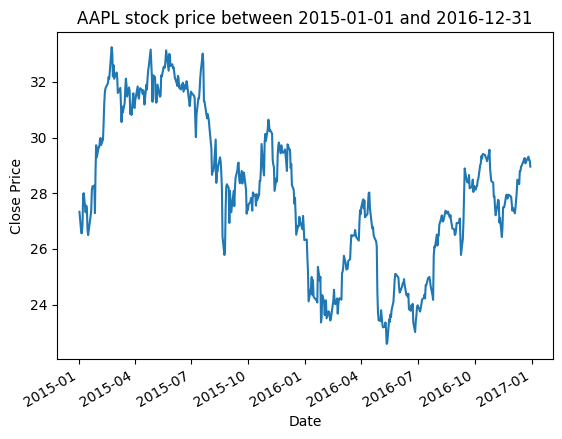

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf


def download_and_plot_stock_price(stock_symbol, start_date, end_date):
    """
    This function downloads the stock price for a given symbol between two dates and plots it.

    :param stock_symbol: str, the symbol of the stock to download
    :param start_date: str, the start date in format 'YYYY-MM-DD'
    :param end_date: str, the end date in format 'YYYY-MM-DD'
    :return: None
    """
    # Download stock data
    data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Plot the close price
    data['Close'].plot()
    plt.title(f'{stock_symbol} stock price between {start_date} and {end_date}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()


def main():
    """
    Main function to execute the script
    """
    # Define the stock symbol and the date range
    stock_symbol = 'AAPL'
    start_date = '2015-01-01'
    end_date = '2016-12-31'

    # Download and plot the stock price
    download_and_plot_stock_price(stock_symbol, start_date, end_date)


if __name__ == '__main__':
    main()